In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [1]:
# === USER INPUT ===
log_dir = "d3rlpy_logs"
algos_to_compare = ["cql", "bear", "bcq", "awac"]  # Change as needed
figsize = (7, 5)
num_per_epoch = 1000
# ==================

In [2]:
def parse_metadata_from_dirname(dirname):
    """
    Parses the directory name of format:
    {algo}_{env}_{batch_size}_{total_steps}_seed_{n}_{timestamp}
    """
    parts = dirname.split("_")
    algo = parts[0]
    batch_size = parts[-5]
    total_steps = parts[-4]
    seed = parts[-2]
    env = "_".join(parts[1:-5])  # everything between algo and batch_size
    return algo, env, batch_size, total_steps, seed


def find_matching_dirs(log_dir, algos, env_name, batch_size, total_steps, seed):
    """
    Finds and returns a list of directories corresponding to all specified algos
    that share the same env, batch_size, total_steps, and seed.
    Returns [] if any algo is missing.
    """
    matched_dirs = {}

    for folder in os.listdir(log_dir):
        full_path = os.path.join(log_dir, folder)
        if not os.path.isdir(full_path):
            continue

        try:
            algo, env, b, t, s = parse_metadata_from_dirname(folder)
        except Exception:
            continue  # skip malformed

        if (
            algo in algos and 
            env == env_name and
            b == str(batch_size) and
            t == str(total_steps) and
            s == str(seed)
        ):
            matched_dirs[algo] = full_path

    # Ensure all specified algos are present
    if all(algo in matched_dirs for algo in algos):
        return [matched_dirs[algo] for algo in algos]
    else:
        return []

def plot_rewards_vs_steps(log_dir, algos, env_name, batch_size, total_steps, seed, plot_steps):
    """
    Finds matching directories and plots reward (col 3) vs steps (col 2)
    for all specified algorithms.
    """
    dirs = find_matching_dirs(log_dir, algos, env_name, batch_size, total_steps, seed)

    if not dirs:
        print("Could not find all matching directories.")
        return

    plt.figure(figsize=figsize)

    for algo, dir_path in zip(algos, dirs):
        csv_path = os.path.join(dir_path, "environment.csv")
        if not os.path.exists(csv_path):
            print(f"Warning: {csv_path} not found, skipping {algo}.")
            continue

        df = pd.read_csv(csv_path, header=None)
        steps = df.iloc[:, 1][:plot_steps//num_per_epoch]
        rewards = df.iloc[:, 2][:plot_steps//num_per_epoch]
        # print(len(steps), len(rewards))
        plt.plot(steps, rewards, label=algo.upper())

    title = f"{env_name} | Batch: {batch_size} | Seed: {seed}"
    plt.title(title)
    plt.xlabel("Total Gradient Steps")
    plt.ylabel("Avg Reward over 10 evaluation trials")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
def smooth_curve(values, window_size=10):
    """
    Moving average that uses expanding window for the first (window_size - 1) points.
    No NaNs, same-length output.
    """
    if isinstance(values, list):
        values = np.array(values)
    if isinstance(values, pd.Series):
        values = values.to_numpy()

    smoothed = np.zeros_like(values, dtype=np.float64)

    for i in range(len(values)):
        start = max(0, i - window_size + 1)
        smoothed[i] = values[start:i+1].mean()

    return smoothed

def plot_smoothed_rewards_vs_steps(log_dir, algos, env_name, batch_size, total_steps, seed, plot_steps, window_size=10):
    """
    Plots smoothed reward (moving average) vs total steps for specified algorithms.
    """
    dirs = find_matching_dirs(log_dir, algos, env_name, batch_size, total_steps, seed)

    if not dirs:
        print("Could not find all matching directories.")
        return

    plt.figure(figsize=figsize)

    for algo, dir_path in zip(algos, dirs):
        csv_path = os.path.join(dir_path, "environment.csv")
        if not os.path.exists(csv_path):
            print(f"Warning: {csv_path} not found, skipping {algo}.")
            continue

        df = pd.read_csv(csv_path, header=None)
        steps = df.iloc[:, 1].to_numpy()[:plot_steps//num_per_epoch]
        rewards = df.iloc[:, 2].to_numpy()[:plot_steps//num_per_epoch]
        rewards_smoothed = smooth_curve(rewards, window_size)

        # Align steps with smoothed rewards
        steps = steps[:len(rewards_smoothed)]

        plt.plot(steps, rewards_smoothed, label=algo.upper())

    title = f"{env_name} | Batch: {batch_size} | Seed: {seed} | MA Window: {window_size}"
    plt.title(title)
    plt.xlabel("Total Gradient Steps")
    plt.ylabel("Avg Reward (smoothed) over 10 evaluation trials")
    plt.ylim([-50, 10000])
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:
# find_matching_dirs(log_dir, algos_to_compare, 'pendulum_expert_v0', 1024, 100000, 1)

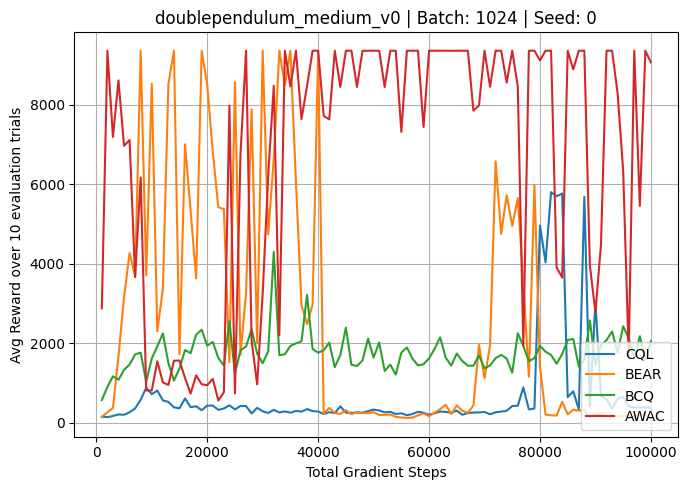

In [8]:
plot_rewards_vs_steps(log_dir, algos_to_compare, 'doublependulum_medium_v0', 1024, 100000, 0, plot_steps=100000)

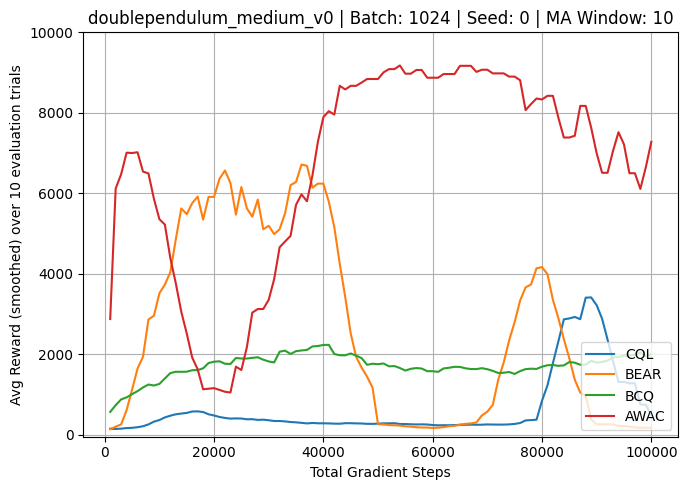

In [19]:
plot_smoothed_rewards_vs_steps(log_dir, algos_to_compare, 'doublependulum_medium_v0', 1024, 100000, 0, plot_steps=100000, window_size=10)

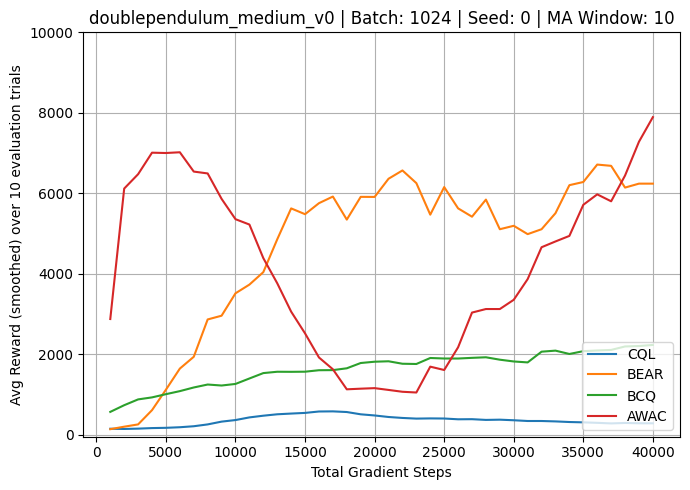

In [20]:
plot_smoothed_rewards_vs_steps(log_dir, algos_to_compare, 'doublependulum_medium_v0', 1024, 100000, 0, plot_steps=40000, window_size=10)

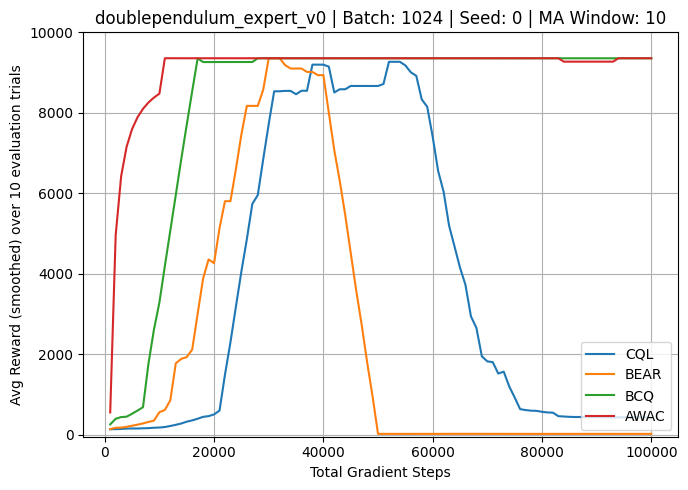

In [21]:
plot_smoothed_rewards_vs_steps(log_dir, algos_to_compare, 'doublependulum_expert_v0', 1024, 100000, 0, plot_steps=100000, window_size=10)

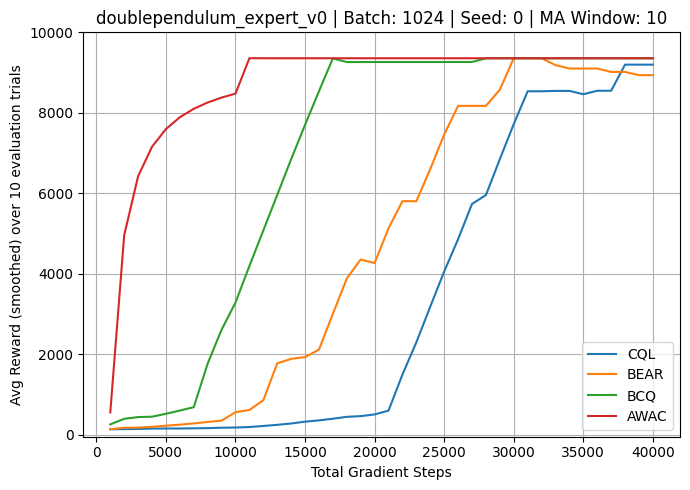

In [22]:
plot_smoothed_rewards_vs_steps(log_dir, algos_to_compare, 'doublependulum_expert_v0', 1024, 100000, 0, plot_steps=40000, window_size=10)